# Chapter 12. 텐서플로를 사용한 사용자 정의 모델과 훈련

# 기본 설정

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version은 코랩 명령입니다.
    %tensorflow_version 2.x
except Exception:
    pass

# 이 노트북은 텐서플로 ≥2.4이 필요합니다
# 2.x 버전은 대부분 동일한 결과를 만들지만 몇 가지 버그가 있습니다.
import tensorflow as tf
from tensorflow import keras
#assert tf.__version__ >= "2.4"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)
tf.random.set_seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
print(tf.__version__)

2.10.0


# 12.1 텐서플로 훑어보기

<텐서플로가 제공하는 것들>  
- GPU 지원(핵심 구조는 numpy와 매우 비슷)
- 분산 컴퓨팅 지원
- 속도를 높이고 메모리 사용량을 줄이기 위해 계산을 최적화
- 한 환경에서 텐서플로 모델을 훈련하고, 다른 환경에서 실행 가능
- 고성능 옵티마이저 제공(ex. RMSProp, Nadam)

# 12.2 넘파이처럼 텐서플로 사용하기

## 12.2.1 텐서와 연산

### <텐서>

`tf.constant()` 함수로 텐서를 만들 수 있음  
텐서는 넘파이 **ndarray**와 매우 비슷함

In [2]:
# 2개의 행과 3개의 열을 가진 실수 행렬 텐서
tf.constant([[1.,2.,3.], [4.,5.,6.]]) # 행렬

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [4]:
# 하나의 스칼라 텐서
tf.constant(42) # 스칼라

<tf.Tensor: shape=(), dtype=int32, numpy=42>

In [5]:
# ndarray와 비슷하게 tf.Tensor는 크기(shape)와 데이터타입(dtype)을 가짐
t = tf.constant([[1.,2.,3.], [4.,5.,6.]])
t

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [6]:
# 텐서의 크기 확인
t.shape

TensorShape([2, 3])

In [7]:
# 텐서의 데이터타입 확인
t.dtype

tf.float32

### <인덱싱>

인덱스 참조도 넘파이와 매우 비슷하게 작동함

In [8]:
# 모든 행, 2번째 열 이후를 출력
t[:, 1:]

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[2., 3.],
       [5., 6.]], dtype=float32)>

아래 코드에서 인덱싱에 사용한 3개의 점의 의미 참고 문서 링크: https://tech.madup.com/python-ellipsis/ 

In [9]:
# tf.newaxis를 안 사용했을 때
t[..., 1]

# shape이 (2,)으로 1차원 배열이 됨

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2., 5.], dtype=float32)>

In [10]:
# tf.newaxis를 사용했을 때
t[..., 1, tf.newaxis]

# shape이 (2,1)로 2차원 배열이 됨

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[2.],
       [5.]], dtype=float32)>

### <연산>

가장 중요한 것은 모든 종류의 텐서 연산이 가능함

In [11]:
# 각 원소별 덧셈
t + 10

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[11., 12., 13.],
       [14., 15., 16.]], dtype=float32)>

In [12]:
# 각 원소별 제곱
tf.square(t)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)>

In [13]:
# @ 연산: 행렬 곱셈을 의미
t @ tf.transpose(t)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[14., 32.],
       [32., 77.]], dtype=float32)>

### <`keras.backend`>

In [14]:
# 케라스 API는 keras.backend에 자체적인 저수준 API를 가지고 있음
# from tensorflow import keras

K = keras.backend
K.square(K.transpose(t)) + 10

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[11., 26.],
       [14., 35.],
       [19., 46.]], dtype=float32)>

## 12.2.2 텐서와 넘파이

넘파이 배열로 텐서를 만들 수 있고, 텐서로 넘파이 배열도 만들 수 있기 때문에  
텐서는 넘파이 배열과 함께 사용하기 편리함(연산 적용도 왔다갔다 할 수 있음)

In [18]:
# 넘파이 배열 -> 텐서
import numpy as np

a = np.array([2.,4.,5.])
tf.constant(a)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([2., 4., 5.])>

In [19]:
# 텐서 -> 넘파이 배열
t.numpy()

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [20]:
# 텐서 -> 넘파이 배열
np.array(t)

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [21]:
# 기본이 넘파이 배열이었던 a를 텐서로 변환해도
# 넘파이 기본 비트인 64비트 정밀도(dtype=float64)는 그대로 남아있음
tf.square(a)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([ 4., 16., 25.])>

In [22]:
# 기본이 텐서였던 t를 넘파이 배열로 변환해도
# 텐서 기본 비트인 32비트 정밀도(dtype=float32)는 그대로 남아있음
np.square(t)

array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)

## 12.2.3 타입 변환

타입 변환은 **성능을 크게 감소시킬 수** 있기 때문에 텐서플로는  
**어떤 타입 변환도 자동으로 수행하지 않음**  

호환되지 않는 타입의 텐서로 연산을 실행하면 에러가 발생

In [23]:
# 실수와 정수의 연산
try:
    tf.constant(2.0) + tf.constant(40)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

cannot compute AddV2 as input #1(zero-based) was expected to be a float tensor but is a int32 tensor [Op:AddV2]


In [24]:
# 비트 정밀도가 다른 실수끼리의 연산
try:
    tf.constant(2.0) + tf.constant(40, dtype=tf.float64)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

cannot compute AddV2 as input #1(zero-based) was expected to be a float tensor but is a double tensor [Op:AddV2]


In [25]:
# 비트 정밀도까지 맞춰줘야 제대로 연산 수행
t2 = tf.constant(40, dtype=tf.float64)
tf.constant(2.0) + tf.cast(t2, tf.float32) # tf.cast: 타입 변환 시 사용

<tf.Tensor: shape=(), dtype=float32, numpy=42.0>

## 12.2.4 변수

지금까지 본 `tf.Tensor`는 **변경이 불가능한 객체**임  
따라서 일반적인 텐서로는 역전파로 변경되어야 하는 신경망의 가중치를 구현할 수 없기 때문에 `tf.Variable`로 변수 할당을 하여야 함 

In [26]:
# 변수 v에 텐서 할당
v = tf.Variable([[1.,2.,3.], [4.,5.,6.]])

In [27]:
# 텐서에서는 assign() 메서드로 변수값 변경 가능
v.assign(2 * v)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2.,  4.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [28]:
# 텐서 행렬의 특정 원소만 변경
v[0,1].assign(42)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [29]:
# 텐서 행렬의 특정 열만 변경
v[:, 2].assign([0.,1.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  0.],
       [ 8., 10.,  1.]], dtype=float32)>

In [31]:
# assign을 사용하지 않으면 error가 남
v[1] = [26.,64.]

TypeError: 'ResourceVariable' object does not support item assignment

In [32]:
# scatter_nd_update: 텐서 행렬의 개별 원소를 수정
v.scatter_nd_update(indices=[[0,0], [1,2]], # 행,열 지정
                   updates=[100.,200.]) # 넣어줄 수 지정

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[100.,  42.,   0.],
       [  8.,  10., 200.]], dtype=float32)>

In [33]:
# scatter_update를 사용하여 바꾸는 방법
sparse_delta = tf.IndexedSlices(values=[[1.,2.,3.], [4.,5.,6.]],
                               indices=[1,0])
v.scatter_update(sparse_delta)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[4., 5., 6.],
       [1., 2., 3.]], dtype=float32)>

## 12.2.5 다른 데이터 구조

텐서플로는 다음과 같은 데이터 구조도 지원함

### <희소 텐서, `tf.SparseTensor`>  
대부분 0으로 채워진 텐서를 효율적으로 나타냄

In [34]:
s = tf.SparseTensor(indices=[[0,1], [1,0], [2,3]],
                   values=[1.,2.,3.],
                   dense_shape=[3,4])

In [35]:
print(s)

SparseTensor(indices=tf.Tensor(
[[0 1]
 [1 0]
 [2 3]], shape=(3, 2), dtype=int64), values=tf.Tensor([1. 2. 3.], shape=(3,), dtype=float32), dense_shape=tf.Tensor([3 4], shape=(2,), dtype=int64))


In [36]:
tf.sparse.to_dense(s)

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0., 1., 0., 0.],
       [2., 0., 0., 0.],
       [0., 0., 0., 3.]], dtype=float32)>

In [37]:
s2 = s * 2.0

In [38]:
# 오류가 날 코드이므로 예외를 출력하게끔 설계
try:
    s3 = s + 1.
except TypeError as ex:
    print(ex)

unsupported operand type(s) for +: 'SparseTensor' and 'float'


In [39]:
s4 = tf.constant([[10., 20.], [30.,40.], [50.,60.], [70.,80.]])
# 3x4 행렬과 4x2 행렬의 행렬 곱셈
tf.sparse.sparse_dense_matmul(s, s4)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[ 30.,  40.],
       [ 20.,  40.],
       [210., 240.]], dtype=float32)>

In [40]:
s5 = tf.SparseTensor(indices=[[0,2], [0,1]],
                    values=[1.,2.],
                    dense_shape=[3,4])
print(s5)

SparseTensor(indices=tf.Tensor(
[[0 2]
 [0 1]], shape=(2, 2), dtype=int64), values=tf.Tensor([1. 2.], shape=(2,), dtype=float32), dense_shape=tf.Tensor([3 4], shape=(2,), dtype=int64))


In [41]:
# 오류가 날 코드이므로 예외를 출력하게끔 설계
try:
    tf.sparse.to_dense(s5)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

{{function_node __wrapped__SparseToDense_device_/job:localhost/replica:0/task:0/device:CPU:0}} indices[1] = [0,1] is out of order. Many sparse ops require sorted indices.
    Use `tf.sparse.reorder` to create a correctly ordered copy.

 [Op:SparseToDense]


In [42]:
# 위 오류에서 대신 사용하라는 것 사용
s6 = tf.sparse.reorder(s5)
tf.sparse.to_dense(s6)

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0., 2., 1., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)>

### <텐서 배열, `tf.TensorArray`>
텐서의 리스트. 리스트에 포함된 모든 텐서는 크기와 데이터 타입이 동일해야 함

In [43]:
array = tf.TensorArray(dtype=tf.float32, size=3) # 데이터 타입, 크기 지정
array = array.write(0, tf.constant([1.,2.]))
array = array.write(1, tf.constant([3.,10.]))
array = array.write(2, tf.constant([5.,7.]))

In [44]:
array.read(1)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 3., 10.], dtype=float32)>

In [45]:
array.stack()

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[1., 2.],
       [0., 0.],
       [5., 7.]], dtype=float32)>

In [46]:
mean, variance = tf.nn.moments(array.stack(), axes=0)
mean

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2., 3.], dtype=float32)>

In [47]:
variance

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([4.6666665, 8.666667 ], dtype=float32)>

### <문자열 텐서, `tf.string`>
유니코드가 아니라 바이트 문자열을 나타냄.

In [48]:
p = tf.constant(["Café", "Coffee", "caffè", "咖啡"])

In [49]:
# 문자열 텐서
tf.strings.length(p, unit='UTF8_CHAR')

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([4, 6, 5, 2])>

In [50]:
r = tf.strings.unicode_decode(p, "UTF-8")
r

<tf.RaggedTensor [[67, 97, 102, 233], [67, 111, 102, 102, 101, 101],
 [99, 97, 102, 102, 232], [21654, 21857]]>

### <래그드 텐서, `tf.RaggedTensor`>
리스트의 리스트를 나타냄. 텐서에 포함된 값은 동일한 데이터 타입을 가져야 하지만 리스트의 길이는 다를 수 있음

In [51]:
# 앞의 문자열 텐서와 이어짐
print(r[1])

tf.Tensor([ 67 111 102 102 101 101], shape=(6,), dtype=int32)


In [52]:
print(r[1:3])

<tf.RaggedTensor [[67, 111, 102, 102, 101, 101], [99, 97, 102, 102, 232]]>


In [54]:
r2 = tf.ragged.constant([[65,66], [], [67]])

# 두 배열 연결 방법: 한 배열 끝에 다른 배열 추가(axis=0)
print(tf.concat([r,r2], axis=0))

<tf.RaggedTensor [[67, 97, 102, 233], [67, 111, 102, 102, 101, 101],
 [99, 97, 102, 102, 232], [21654, 21857], [65, 66], [], [67]]>


In [55]:
r3 = tf.ragged.constant([[68, 69, 70], [71], [], [72, 73]])

# 두 배열 연결 방법: 한 배열의 같은 위치에 다른 배열 추가(axis=1)
print(tf.concat([r,r3], axis=1))

<tf.RaggedTensor [[67, 97, 102, 233, 68, 69, 70], [67, 111, 102, 102, 101, 101, 71],
 [99, 97, 102, 102, 232], [21654, 21857, 72, 73]]>


In [56]:
tf.strings.unicode_encode(r3, "UTF-8")

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'DEF', b'G', b'', b'HI'], dtype=object)>

In [57]:
r.to_tensor()

<tf.Tensor: shape=(4, 6), dtype=int32, numpy=
array([[   67,    97,   102,   233,     0,     0],
       [   67,   111,   102,   102,   101,   101],
       [   99,    97,   102,   102,   232,     0],
       [21654, 21857,     0,     0,     0,     0]])>

### <집합, `tf.sets`>
집합은 일반적인 텐서(or 희소 텐서)로 나타냄  
ex) tf.constant([[1,2], [3,4]])는 2개의 집합 {1,2}, {3,4}를 나타냄

In [58]:
set1 = tf.constant([[2,3,5,7], [7,9,0,0]])
set2 = tf.constant([[4,5,6], [9,10,0]])
tf.sparse.to_dense(tf.sets.union(set1,set2))

<tf.Tensor: shape=(2, 6), dtype=int32, numpy=
array([[ 2,  3,  4,  5,  6,  7],
       [ 0,  7,  9, 10,  0,  0]])>

In [59]:
tf.sparse.to_dense(tf.sets.difference(set1, set2))

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[2, 3, 7],
       [7, 0, 0]])>

In [60]:
tf.sparse.to_dense(tf.sets.intersection(set1,set2))

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[5, 0],
       [0, 9]])>

# 12.3 사용자 정의 모델과 훈련 알고리즘

## 12.3.1 사용자 정의 손실 함수

캘리포니아 주택 데이터셋을 로드하여 준비  
우선 데이터셋을 로드한 다음 훈련, 검증, 테스트 세트로 나눈 뒤 `StandardScaler()`로 스케일 조정

In [4]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 데이터셋 로드
housing = fetch_california_housing()

# 훈련, 검증, 테스트 세트로 분리
X_train_full, X_test, y_train_full, y_test = train_test_split(
housing.data, housing.target.reshape(-1,1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
X_train_full, y_train_full, random_state=42)

# 스케일 조정
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

**후버(Huber) 손실**을 사용하기 위해 사용자 정의 손실 함수로 이를 구현:

In [5]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

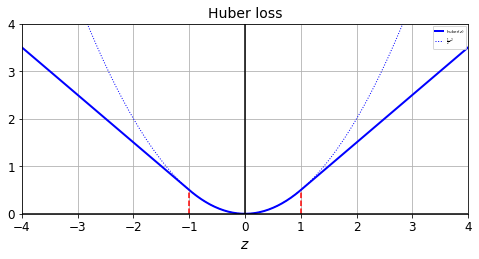

In [6]:
# 후버 손실을 그래프로 시각화
plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
plt.plot(z, huber_fn(0, z), 'b-', linewidth=2, label='huber($z$)')
plt.plot(z, z**2 / 2, 'b:', linewidth=1, label=r'$\frac{1}{2}z^2$')
plt.plot([-1,-1], [0, huber_fn(0.,-1.)], 'r--')
plt.plot([1,1], [0, huber_fn(0.,1.)], 'r--')
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel('$z$')
plt.legend(fontsize=4)
plt.title("Huber loss", fontsize=14)
plt.show()

In [7]:
# 입력 데이터 형태 지정
input_shape = X_train.shape[1:]

# 시퀀셜 API로 모델 쌓기
model = keras.models.Sequential([
    keras.layers.Dense(30, activation='selu', kernel_initializer='lecun_normal',
                      input_shape=input_shape), 
    keras.layers.Dense(1)
])

# 앞서 만든 후버 손실을 적용하여 모델 컴파일
model.compile(loss=huber_fn, optimizer='nadam', metrics=['mae'])

In [8]:
# 모델 훈련
model.fit(X_train_scaled, y_train, epochs=2,
         validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 4s 5ms/step - loss: 0.5821 - mae: 0.9386 - val_loss: 0.2510 - val_mae: 0.5465
Epoch 2/2
363/363 [==============================] - 1s 4ms/step - loss: 0.2136 - mae: 0.5073 - val_loss: 0.1982 - val_mae: 0.4886


## 12.3.2 사용자 정의 요소를 가진 모델을 저장하고 로드하기

In [9]:
# 모델 저장
model.save('my_model_with_a_custom_loss.h5')

모델을 로드(load)할 때는 함수 이름과 실제 함수를 매핑한 딕셔너리를 전달해야 함

In [10]:
# 모델 로드
model = keras.models.load_model('my_model_with_a_custom_loss.h5',
                               custom_objects={'huber_fn': huber_fn})

In [11]:
# 로드한 모델 작동 확인
model.fit(X_train_scaled, y_train, epochs=2,
         validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 3s 5ms/step - loss: 0.2019 - mae: 0.4917 - val_loss: 0.1905 - val_mae: 0.4744
Epoch 2/2
363/363 [==============================] - 2s 4ms/step - loss: 0.1959 - mae: 0.4822 - val_loss: 0.2076 - val_mae: 0.4925


In [12]:
# 매개변수를 받을 수 있는 함수 정의
def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold # 매개변수 받는 부분
        squared_loss = tf.square(error) / 2
        linear_loss = threshold * tf.abs(error) - threshold**2 / 2 # 매개변수 받는 부분
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn

In [13]:
# 모델 컴파일
model.compile(loss=create_huber(2.0), optimizer='nadam', metrics=['mae'])

In [14]:
# 모델 훈련
model.fit(X_train_scaled, y_train, epochs=2,
         validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 4s 5ms/step - loss: 0.2182 - mae: 0.4809 - val_loss: 0.2295 - val_mae: 0.4754
Epoch 2/2
363/363 [==============================] - 1s 4ms/step - loss: 0.2130 - mae: 0.4767 - val_loss: 0.2302 - val_mae: 0.4801


In [15]:
# 모델 저장
model.save('my_model_with_a_custom_loss_threshold_2.h5')

위에서 모델 저장 시 threshold 값은 저장되지 않음  
따라서 모델을 로드할 때 threshold 값을 지정해주어야 함:

In [16]:
model = keras.models.load_model('my_model_with_a_custom_loss_threshold_2.h5',
                               custom_objects={'huber_fn': create_huber(2.0)})

In [17]:
model.fit(X_train_scaled, y_train, epochs=2,
         validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 3s 5ms/step - loss: 0.2098 - mae: 0.4714 - val_loss: 0.1966 - val_mae: 0.4541
Epoch 2/2
363/363 [==============================] - 1s 4ms/step - loss: 0.2054 - mae: 0.4662 - val_loss: 0.2281 - val_mae: 0.4745


threshold 값이 저장되지 않는 문제는 **keras.losses.Loss** 클래스를 상속하고 `get_config()` 메서드를 구현하여 해결할 수 있음:

In [18]:
class HuberLoss(keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)
    def call(self, y_true, y_pred): # 이 부분이 앞서 만든 huber_fn과 일치
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, 'threshold': self.threshold}

In [19]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation='selu', kernel_initializer='lecun_normal',
                      input_shape=input_shape), 
    keras.layers.Dense(1)
])

# 앞서 만든 후버 손실 클래스를 적용하여 모델 컴파일
model.compile(loss=HuberLoss(2.), optimizer='nadam', metrics=['mae'])

In [20]:
model.fit(X_train_scaled, y_train, epochs=2,
         validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 2ms/step - loss: 0.8292 - mae: 0.9657 - val_loss: 0.4128 - val_mae: 0.5991
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2456 - mae: 0.5129 - val_loss: 0.3200 - val_mae: 0.5364


In [21]:
# 모델 저장
model.save('my_model_with_a_custom_loss_class.h5')

In [22]:
# 모델 로드
model = keras.models.load_model('my_model_with_a_custom_loss_class.h5',
                               custom_objects={'HuberLoss': HuberLoss})

In [23]:
# 잘 작동하는지 확인
model.fit(X_train_scaled, y_train, epochs=2,
         validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2281 - mae: 0.4959 - val_loss: 0.2305 - val_mae: 0.4835
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2194 - mae: 0.4876 - val_loss: 0.2213 - val_mae: 0.4795


In [24]:
# threshold 확인
model.loss.threshold

2.0

## 12.3.3 활성화 함수, 초기화, 규제, 제한을 커스터마이징하기

손실, 규제, 제한, 초기화, 지표, 활성화 함수, 층, 모델과 같은 대부분의 케라스 기능은 유사한 방법으로 커스터마이징할 수 있음

In [25]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [26]:
# 사용자 정의 활성화 함수
def my_softplus(z): # tf.nn.softplus(z) 값을 반환
    return tf.math.log(tf.exp(z) + 1.0)

# 사용자 정의 글로럿 초기화
def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

# 사용자 정의 l1 규제
def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

# 사용자 정의 제한(양수인 가중치만 남김)
def my_positive_weights(weights): # tf.nn.relu(weights) 값을 반환
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

In [27]:
# 만든 사용자 정의 함수는 보통의 함수처럼 동일하게 사용 가능
layer = keras.layers.Dense(1, activation=my_softplus,
                          kernel_initializer=my_glorot_initializer,
                          kernel_regularizer=my_l1_regularizer,
                          kernel_constraint=my_positive_weights)

In [28]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [29]:
# 위에서 만든 사용자 정의 레이어로 모델 정의
model = keras.models.Sequential([
    keras.layers.Dense(30, activation='selu', kernel_initializer='lecun_normal',
                      input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus, 
                       kernel_initializer=my_glorot_initializer, 
                       kernel_regularizer=my_l1_regularizer, 
                       kernel_constraint=my_positive_weights)
])

In [30]:
model.compile(loss='mse', optimizer='nadam', metrics=['mae'])

In [31]:
model.fit(X_train_scaled, y_train, epochs=2,
         validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 2ms/step - loss: 1.8219 - mae: 0.9688 - val_loss: inf - val_mae: inf
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.6287 - mae: 0.5379 - val_loss: inf - val_mae: inf


In [32]:
# 모델 저장
model.save('my_model_with_many_custom_parts.h5')

In [34]:
# 모델 로드 시 마찬가지로 custom_objects에 각각을 설정해주어야 함
model = keras.models.load_model(
'my_model_with_many_custom_parts.h5',
custom_objects={
    'my_l1_regularizer': my_l1_regularizer,
    'my_positive_weights': my_positive_weights,
    'my_glorot_initializer': my_glorot_initializer,
    'my_softplus': my_softplus
})

앞서 사용자 정의 손실을 만들었던 것처럼 factor 하이퍼파라미터를 저장하는 l1 규제를 위한 클래스를 만들면 다음과 같음:

In [35]:
class MyL1Regularizer(keras.regularizers.Regularizer):
    def __init__(self, factor):
        self.factor = factor
    def __call__(self, weights):
        return tf.reduce_sum(tf.abs(self.factor * weights))
    def get_config(self):
        return {"factor": self.factor}

In [36]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [37]:
# 위에서 만든 l1 규제 클래스를 활용하여 모델 정의
model = keras.models.Sequential([
    keras.layers.Dense(30, activation='selu', kernel_initializer='lecun_normal',
                      input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus, 
                       kernel_initializer=my_glorot_initializer, 
                       kernel_regularizer=MyL1Regularizer(0.01), # 이 부분
                       kernel_constraint=my_positive_weights)
])

model.compile(loss='mse', optimizer='nadam', metrics=['mae'])

In [38]:
model.fit(X_train_scaled, y_train, epochs=2,
         validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 2ms/step - loss: 2.4456 - mae: 1.1056 - val_loss: inf - val_mae: inf
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.6951 - mae: 0.5444 - val_loss: inf - val_mae: inf


In [39]:
# 동일한 명으로 모델 저장(덮어쓰기)
model.save('my_model_with_many_custom_parts.h5')

In [40]:
# 모델 로드 시 마찬가지로 custom_objects에 각각을 설정해주어야 함
model = keras.models.load_model(
'my_model_with_many_custom_parts.h5',
custom_objects={
    'MyL1Regularizer': MyL1Regularizer,
    'my_positive_weights': my_positive_weights,
    'my_glorot_initializer': my_glorot_initializer,
    'my_softplus': my_softplus
})

## 12.3.4 사용자 정의 지표

In [41]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [42]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

대부분의 경우 사용자 지표 함수를 만드는 것은 사용자 손실 함수를 만드는 것과 동일함  
앞서 만든 *후버 손실 함수*는 지표(metrics)로 사용해도 잘 동작함:

In [43]:
model.compile(loss='mse', optimizer='nadam', metrics=[create_huber(2.0)])

In [44]:
model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 2.3473 - huber_fn: 0.9726
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.5336 - huber_fn: 0.2575


**(주의)** 손실과 지표에 같은 함수를 사용하더라도 **다른 결과가 나올 수 있음!** 이는 일반적으로 부동 소수점 정밀도 오차와 연산 순서 때문임  
- 에포크에서의 손실(loss): 지금까지 본 모든 배치 손실의 평균
- 에포크에서의 지표(metrics): 모든 샘플 손실의 가중 평균  

수학적으로 표현하면 **손실 = 지표 * 샘플 가중치의 평균(+약간의 부동 소수점 정밀도 오차)** 임

In [45]:
# 손실과 지표에 같은 후버 함수 적용
model.compile(loss=create_huber(2.0), optimizer='nadam', metrics=[create_huber(2.0)])

In [46]:
sample_weight = np.random.rand(len(y_train))
history = model.fit(X_train_scaled, y_train, epochs=2, sample_weight=sample_weight)

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 0.1183 - huber_fn: 0.2392
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.1132 - huber_fn: 0.2283


In [47]:
# 손실과 지표의 차이 확인
history.history['loss'][0], history.history['huber_fn'][0] * sample_weight.mean()

(0.11826641112565994, 0.1187083839469503)

### 스트리밍 지표(상태가 있는 지표)
지금까지의 전체 정밀도를 계산, `keras.metrics.Precision()`으로 구현

In [48]:
precision = keras.metrics.Precision()

# 첫 번째 배치의 정밀도
precision([0, 1, 1, 1, 0, 1, 0, 1], [1, 1, 0, 1, 0, 1, 0, 1])

<tf.Tensor: shape=(), dtype=float32, numpy=0.8>

In [49]:
# 두 번째 배치의 정밀도가 아닌 지금까지 전체 정밀도
precision([0, 1, 0, 0, 1, 0, 1, 1], [1, 0, 1, 1, 0, 0, 0, 0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [50]:
# 최종 정밀도 출력결과가 결국 지금까지의 전체 정밀도와 같음
precision.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [51]:
# 진짜 양성과 거짓 양성을 기록한 변수 확인
precision.variables

[<tf.Variable 'true_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>,
 <tf.Variable 'false_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>]

In [52]:
# 변수 초기화
precision.reset_states()

이런 스트리밍 지표를 만들려면 **keras.metrics.Metric** 클래스를 상속하여 아래와 같이 전체 후버 손실과 지금까지 처리한 샘플 수를 기록하는 클래스를 만들어야 함  
이때 결과값을 요청하면 평균 후버 손실이 반환됨

In [53]:
class HuberMetric(keras.metrics.Metric):
    def __init__(self, threshold=1.0, **kwargs):
        super().__init__(**kwargs) # 기본 매개변수 처리
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        self.total = self.add_weight('total', initializer='zeros') # 후버 손실의 합을 기록
        self.count = self.add_weight('count', initializer='zeros') # 지금까지 처리한 샘플 수를 기록
    
    # 앞서 precision에서 했던 것처럼 배치의 레이블과 예측을 바탕으로 변수를 업데이트
    def update_state(self, y_true, y_pred, sample_weight=None): 
        metric = self.huber_fn(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(metric))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))
    
    # 최종 결과를 계산하여 반환
    def result(self):
        return self.total / self.count
    
    # threshold 변수를 모델과 함께 저장
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, 'threshold': self.threshold}

In [54]:
# HuberMetric 테스트
m = HuberMetric(2.)

# <실제 계산 과정>
# total = 2 * |10 - 2| - 2²/2 = 14
# count = 1
# result = 14 / 1 = 14
m(tf.constant([[2.]]), tf.constant([[10.]]))

<tf.Tensor: shape=(), dtype=float32, numpy=14.0>

In [55]:
# <실제 계산 과정>
# total = total + (|1 - 0|² / 2) + (2 * |9.25 - 5| - 2² / 2) = 14 + 7 = 21
# count = count + 2 = 3
# result = total / count = 21 / 3 = 7
m(tf.constant([[0.], [5.]]), tf.constant([[1.], [9.25]]))

m.result()

<tf.Tensor: shape=(), dtype=float32, numpy=7.0>

In [56]:
# total과 count를 기록한 변수 확인
m.variables

[<tf.Variable 'total:0' shape=() dtype=float32, numpy=21.0>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=3.0>]

In [57]:
# 변수 초기화 후 초기화 확인
m.reset_states()
m.variables

[<tf.Variable 'total:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=0.0>]

`HuberMetric` 클래스가 실제 모델에서도 잘 동작하는지 테스트:

In [58]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [59]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

# 지표에 HuberMetric 클래스 사용
model.compile(loss=create_huber(2.0), optimizer='nadam', metrics=[HuberMetric(2.0)])

In [60]:
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.9386 - huber_metric: 0.9386
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2511 - huber_metric: 0.2511


In [61]:
# HuberMetric에 접근
model.metrics[-1].threshold

2.0

앞서 만든 `HuberMetric` 클래스를 아래와 같이 더 짧게 만들 수 있다고 함:

In [62]:
# 변한 부분: __init__과 update_state 부분이 변경, result는 없어짐
class HuberMetric(keras.metrics.Mean):
    def __init__(self, threshold=1.0, name='HuberMetric', dtype=None):
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        super().__init__(name=name, dtype=dtype)
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        super(HuberMetric, self).update_state(metric, sample_weight)
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, 'threshold': self.threshold}
    
# 이렇게 만든 클래스는 크기를 더 잘 처리하고 샘플 가중치도 지원함

In [63]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [65]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

# 지표에 HuberMetric 클래스 사용
model.compile(loss=keras.losses.Huber(2.0), optimizer="nadam", weighted_metrics=[HuberMetric(2.0)])

In [66]:
# 샘플 가중치까지 추가된 모습
sample_weight = np.random.rand(len(y_train))
history = model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), 
                    epochs=2, sample_weight=sample_weight)

Epoch 1/2
363/363 [==============================] - 2s 2ms/step - loss: 0.4409 - HuberMetric: 0.8885
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.1213 - HuberMetric: 0.2444


In [67]:
# 손실과 지표값 확인
history.history["loss"][0], history.history["HuberMetric"][0] * sample_weight.mean()

(0.4408967196941376, 0.4408968257054267)

In [68]:
# 모델 저장
model.save('my_model_with_a_custom_metric_v2.h5')

In [70]:
# 모델 로드 시 custom_objects 지정
model = keras.models.load_model('my_model_with_a_custom_metric_v2.h5',
                               custom_objects={'HuberMetric': HuberMetric})

In [71]:
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2353 - HuberMetric: 0.2353
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2284 - HuberMetric: 0.2284


In [72]:
# HuberMetric에 접근
model.metrics[-1].threshold

2.0

## 12.3.5 사용자 정의 층

텐서플로에는 없는 특이한 층을 가진 네트워크를 만들어야 할 때가 있는 경우, 직접 사용자 정의 층을 만들 수 있음

In [77]:
# 입력에 지수 함수를 적용하는 층 예시
exponential_layer = keras.layers.Lambda(lambda x: tf.exp(x))

# 결과 test
exponential_layer([-1., 0., 1.])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.36787945, 1.        , 2.7182817 ], dtype=float32)>

위와 같은 지수 함수 층은 회귀 모델이 예측할 값이 양수이고 스케일이 매우 다른 경우(ex. 0.001, 10, 10000) 출력층에 이러한 지수 함수를 추가하면 유용할 수 있음:

In [78]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [80]:
# 모델의 출력층에 위에서 만든 지수 함수 층 추가
model = keras.models.Sequential([
    keras.layers.Dense(30, activation='relu', input_shape=input_shape),
    keras.layers.Dense(1),
    exponential_layer # 지수 함수 층
])

model.compile(loss='mse', optimizer='sgd')

In [81]:
model.fit(X_train_scaled, y_train, epochs=5,
         validation_data=(X_valid_scaled, y_valid))

model.evaluate(X_test_scaled, y_test)

Epoch 1/5
363/363 [==============================] - 1s 2ms/step - loss: 0.6905 - val_loss: 0.4161
Epoch 2/5
363/363 [==============================] - 1s 2ms/step - loss: 0.4366 - val_loss: 0.3763
Epoch 3/5
363/363 [==============================] - 1s 1ms/step - loss: 0.4112 - val_loss: 0.3611
Epoch 4/5
363/363 [==============================] - 1s 1ms/step - loss: 0.4194 - val_loss: 0.3582
Epoch 5/5
162/162 [==============================] - 0s 1ms/step - loss: 0.3798


0.37976232171058655

상태가 있는 층(즉, 가중치를 가진 층)을 만들려면 `keras.layers.Layer`를 상속해야 함  
예를 들어 아래의 클래스는 Dense 층의 간소화 버전을 구현한 것임:

In [82]:
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)
        
    # 가중치마다 add_weights() 메서드를 호출하여 층의 변수를 만듦
    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
        name='kernel', shape=[batch_input_shape[-1], self.units],
        initializer='glorot_normal')
        self.bias = self.add_weight(
        name='bias', shape=[self.units], initializer='zeros')
        super().build(batch_input_shape)
        
    # 이 층에 필요한 연산을 수행
    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)
    
    # 이 층의 출력 크기를 반환
    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])
    
    # 활성화 함수의 전체 설정을 저장
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, 'units':self.units,
               "activation": keras.activations.serialize(self.activation)}

In [83]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [85]:
# 직접 만든 Dense 층으로 모델 만들기
model = keras.models.Sequential([
    MyDense(30, activation="relu", input_shape=input_shape),
    MyDense(1)
])

model.compile(loss="mse", optimizer="nadam")

In [86]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

model.evaluate(X_test_scaled, y_test)

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 1.5867 - val_loss: 2.5433
Epoch 2/2
162/162 [==============================] - 0s 1ms/step - loss: 0.4789


0.4789492189884186

In [87]:
model.save("my_model_with_a_custom_layer.h5")

In [88]:
model = keras.models.load_model("my_model_with_a_custom_layer.h5",
                                custom_objects={"MyDense": MyDense})

여러 가지 입력을 받는 층을 만들려면 call() 메서드에 모든 입력이 포함된 튜플을 매개변수 값으로 전달해야 함  
예시로 아래는 두 개의 입력과 세 개의 출력을 만드는 층임:

In [89]:
class MyMultiLayer(keras.layers.Layer):
    def call(self, X):
        X1, X2 = X
        print('X1.shape: ', X1.shape, 'X2.shape: ', X2.shape)
        return X1 + X2, X1 * X2
    
    def compute_output_shape(self, batch_input_shape):
        batch_input_shape1, batch_input_shape2 = batch_input_shape
        return [batch_input_shape1, batch_input_shape2]

위 층은 함수형 API와 서브클래싱 API에는 사용할 수 있지만  
(하나의 입력과 하나의 출력을 가진 층만 사용하는) 시퀀셜 API에는 사용할 수 없음

In [90]:
# 함수형 API를 사용해 호출한 모습
inputs1 = keras.layers.Input(shape=[2])
inputs2 = keras.layers.Input(shape=[2])
outputs1, outputs2 = MyMultiLayer()((inputs1, inputs2))

X1.shape:  (None, 2) X2.shape:  (None, 2)


`call()` 메서드는 심볼릭 입력을 받는데, 이 입력의 크기는 부분적으로만 지정되어 있기 때문에 이 시점에서는 배치 크기를 모름. 그래서 위 결과에서 첫 번째 차원이 None인 것임  

사용자 층에 실제 데이터를 전달할 수도 있음. 이를 테스트하기 위해 각 데이터셋의 입력을 각각 4개의 특성을 가진 두 부분으로 나누겠음:

In [91]:
def split_data(data):
    columns_count = data.shape[-1]
    half = columns_count // 2
    return data[:, :half], data[:, half:]

# 데이터셋의 입력을 두 부분으로 분할
X_train_scaled_A, X_train_scaled_B = split_data(X_train_scaled)
X_valid_scaled_A, X_valid_scaled_B = split_data(X_valid_scaled)
X_test_scaled_A, X_test_scaled_B = split_data(X_test_scaled)

# 분할된 데이터 크기 출력
X_train_scaled_A.shape, X_train_scaled_B.shape

((11610, 4), (11610, 4))

In [92]:
outputs1, outputs2 = MyMultiLayer()((X_train_scaled_A, X_train_scaled_B))

X1.shape:  (11610, 4) X2.shape:  (11610, 4)


아까와는 다르게 첫 번째 차원까지 11610으로 완전하게 지정되었음  

이제 함수형 API로 완전한 모델을 만들어보겠음:

In [93]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [94]:
input_A = keras.layers.Input(shape=X_train_scaled_A.shape[-1])
input_B = keras.layers.Input(shape=X_train_scaled_B.shape[-1])
hidden_A, hidden_B = MyMultiLayer()((input_A, input_B)) # 사용자 정의 층
hidden_A = keras.layers.Dense(30, activation='selu')(hidden_A)
hidden_B = keras.layers.Dense(30, activation='selu')(hidden_B)
concat = keras.layers.Concatenate()((hidden_A, hidden_B))
output = keras.layers.Dense(1)(concat)

# 앞에서 만든 함수형 API로 모델 생성
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

X1.shape:  (None, 4) X2.shape:  (None, 4)


In [95]:
# 모델 컴파일
model.compile(loss='mse', optimizer='nadam')

In [96]:
# 모델 훈련
model.fit((X_train_scaled_A, X_train_scaled_B), y_train, epochs=2,
          validation_data=((X_valid_scaled_A, X_valid_scaled_B), y_valid))

Epoch 1/2
X1.shape:  (None, 4) X2.shape:  (None, 4)
X1.shape:  (None, 4) X2.shape:  (None, 4)
363/363 [==============================] - 2s 2ms/step - loss: 1.9056 - val_loss: 1.0586
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.9884 - val_loss: 1.0695


훈련과 테스트에서 다르게 동작하는 가우시안 층을 만들면 아래와 같음:

In [97]:
class AddGaussianNoise(keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev
    
    # 훈련과 테스트에서의 동작이 달라지는 부분
    def call(self, X, training=None):
        if training:
            noise = tf.random.normal(tf.shape(X), stddev=self.stddev)
            return X + noise
        else:
            return X
        
    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

위 사용자 정의 층을 모델 생성에 사용하면 아래와 같음:

In [98]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [99]:
model = keras.models.Sequential([
    AddGaussianNoise(stddev=1.0), # 사용자 정의 층
    keras.layers.Dense(30, activation="selu"),
    keras.layers.Dense(1)
])

In [100]:
# 모델 컴파일
model.compile(loss="mse", optimizer="nadam")

In [101]:
# 모델 훈련 후 평가
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

model.evaluate(X_test_scaled, y_test)

Epoch 1/2
363/363 [==============================] - 2s 2ms/step - loss: 2.2515 - val_loss: 3.4451
Epoch 2/2
162/162 [==============================] - 0s 1ms/step - loss: 0.7495


0.7494564652442932

## 12.3.6 사용자 정의 모델

캘리포니아 주택 데이터셋 다시 로드

In [2]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 데이터셋 로드
housing = fetch_california_housing()

# 훈련, 검증, 테스트 세트로 분리
X_train_full, X_test, y_train_full, y_test = train_test_split(
housing.data, housing.target.reshape(-1,1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
X_train_full, y_train_full, random_state=42)

# 스케일 조정
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [3]:
# 사본 생성
X_new_scaled = X_test_scaled

In [4]:
# 모델에 재사용 가능한 잔차 블록 층 클래스 정의
class ResidualBlock(keras.layers.Layer):
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(n_neurons, activation='elu',
                                         kernel_initializer='he_normal')
                      for _ in range(n_layers)]
        
    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        return inputs + Z

In [5]:
# 서브클래싱 API를 사용해 모델 정의
class ResidualRegressor(keras.models.Model):
    # 생성자에서 층 만듦
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(30, activation='elu',
                                         kernel_initializer='he_normal')
        self.block1 = ResidualBlock(2, 30)
        self.block2 = ResidualBlock(2, 30)
        self.out = keras.layers.Dense(output_dim)
    
    # 메소드에서 앞서 만든 층 사용
    def call(self, inputs):
        Z = self.hidden1(inputs)
        for _ in range(1 + 3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)

In [6]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [7]:
# 정의한 모델로 학습, 평가, 예측 수행
model = ResidualRegressor(1)
model.compile(loss='mse', optimizer='nadam')

history = model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
363/363 [==============================] - 3s 2ms/step - loss: 7.2066
Epoch 2/5
363/363 [==============================] - 1s 2ms/step - loss: 1.4774
Epoch 3/5
363/363 [==============================] - 1s 2ms/step - loss: 0.6727
Epoch 4/5
363/363 [==============================] - 1s 2ms/step - loss: 0.5928
Epoch 5/5
363/363 [==============================] - 1s 2ms/step - loss: 0.5190


In [8]:
score = model.evaluate(X_test_scaled, y_test)

y_pred = model.predict(X_new_scaled)

162/162 [==============================] - 0s 1ms/step


In [9]:
# 모델 저장: 형식이 h5가 아니라 ckpt임
model.save('my_custom_model.ckpt')

INFO:tensorflow:Assets written to: my_custom_model.ckpt\assets


INFO:tensorflow:Assets written to: my_custom_model.ckpt\assets


In [10]:
# 모델 로드
model = keras.models.load_model('my_custom_model.ckpt')

In [11]:
# 불러온 모델로 다시 훈련
history = model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
363/363 [==============================] - 2s 2ms/step - loss: 0.7520
Epoch 2/5
363/363 [==============================] - 1s 2ms/step - loss: 0.7469
Epoch 3/5
363/363 [==============================] - 1s 2ms/step - loss: 0.5528
Epoch 4/5
363/363 [==============================] - 1s 2ms/step - loss: 0.4385
Epoch 5/5
363/363 [==============================] - 1s 2ms/step - loss: 0.4321


In [12]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

앞서 서브클래싱 API 모델 말고 그전에 만든 잔차 블록 층을 가지고  
시퀀셜 API로 모델을 정의할 수도 있음:

In [13]:
block1 = ResidualBlock(2, 30)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation='elu', kernel_initializer='he_normal'), 
    block1, block1, block1, block1,
    ResidualBlock(2, 30),
    keras.layers.Dense(1)
])

In [14]:
# 이후 과정은 전과 동일
model.compile(loss="mse", optimizer="nadam")

history = model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
363/363 [==============================] - 2s 2ms/step - loss: 1.4487
Epoch 2/5
363/363 [==============================] - 1s 2ms/step - loss: 0.5339
Epoch 3/5
363/363 [==============================] - 1s 2ms/step - loss: 0.3972
Epoch 4/5
363/363 [==============================] - 1s 2ms/step - loss: 0.4393
Epoch 5/5
363/363 [==============================] - 1s 2ms/step - loss: 0.4286


In [15]:
score = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_new_scaled)

162/162 [==============================] - 0s 1ms/step


## 12.3.7 모델 구성 요소에 기반한 손실과 지표

다음은 사용자 정의 재구성 손실을 가지는 모델을 만드는 코드임:

In [19]:
class ReconstructingRegressor(keras.Model):
    # 생성자: 5개의 은닉층과 1개의 출력층으로 구성된 심층 신경망을 만듦
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(30, activation='selu',
                                         kernel_initializer='lecun_normal')
                      for _ in range(5)]
        self.out = keras.layers.Dense(output_dim)
        self.reconstruction_mean = keras.metrics.Mean(name='reconstruction_error')
    
    # build 메서드: 완전 연결 층을 하나 더 추가하여 모델의 입력을 재구성함
    def build(self, batch_input_shape):
        n_inputs = batch_input_shape[-1]
        self.reconstruct = keras.layers.Dense(n_inputs)
        # 이 부분이 텐서플로우 2.2에 있는 오류로 삭제되었다고 함
        # super().build(batch_input_shape)
    
    # call 메서드: 입력이 5개인 은닉층에 모두 통과
    def call(self, inputs, training=None):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        reconstruction = self.reconstruct(Z)
        self.recon_loss = 0.05 + tf.reduce_mean(tf.square(reconstruction - inputs))
        
        if training:
            result = self.reconstruction_mean(recon_loss)
            self.add_metric(result)
        return self.out(Z)
    
    def train_step(self, data):
        x, y = data
        
        with tf.GradientTape() as tape:
            y_pred = self(x)
            loss = self.compiled_loss(y, y_pred, regularization_losses=[self.recon_loss])
        
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        return {m.name: m.result() for m in self.metrics}

In [20]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [21]:
# 앞서 정의한 사용자 정의 재구성 손실을 가지는 모델 사용
model = ReconstructingRegressor(1)

model.compile(loss="mse", optimizer="nadam")

In [22]:
history = model.fit(X_train_scaled, y_train, epochs=2)

y_pred = model.predict(X_test_scaled)

Epoch 1/2
363/363 [==============================] - 2s 2ms/step - loss: 1.3493 - reconstruction_error: 0.0000e+00
Epoch 2/2
162/162 [==============================] - 0s 1ms/step


## 12.3.8 자동미분을 사용하여 그레이디언트 계산하기

In [23]:
# 간단한 이차함수 정의
def f(w1, w2):
    return 3 * w1 ** 2 + 2 * w1 * w2

In [24]:
# 포인트 (w1, w2) = (5, 3)에서 도함수 값 계산
w1, w2 = 5, 3
eps = 1e-6
(f(w1 + eps, w2) - f(w1, w2)) / eps

36.000003007075065

In [25]:
(f(w1, w2 + eps) - f(w1, w2)) / eps

10.000000003174137

In [27]:
# 텐서플로우의 자동미분 계산 확인
w1, w2 = tf.Variable(5.), tf.Variable(3.)
with tf.GradientTape() as tape:
    z = f(w1, w2)

gradients = tape.gradient(z, [w1, w2])

gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

`gradient()` 메서드가 호출된 후에는 자동으로 테이프가 즉시 지워지기 때문에  
메서드를 두 번 호출하면 에러가 발생함:

In [30]:
with tf.GradientTape() as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)
dz_dw1

<tf.Tensor: shape=(), dtype=float32, numpy=36.0>

In [31]:
# 예외 발생 부분을 에러가 출력되게 짬
try:
    dz_dw2 = tape.gradient(z, w2)
except RuntimeError as ex:
    print(ex)

A non-persistent GradientTape can only be used to compute one set of gradients (or jacobians)


따라서 `gradient()` 메서드를 한 번 이상 호출해야 한다면  
지속 가능한 테이프를 만들고 사용이 끝난 뒤 테이프를 삭제하여 리소스를 해제해야 함:

In [32]:
with tf.GradientTape(persistent=True) as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)
dz_dw2 = tape.gradient(z, w2)
del tape

In [33]:
# 결과 확인
dz_dw1, dz_dw2

(<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>)

만약 변수가 아닌 다른 객체에 대한 z의 그레이디언트를 계산하면 None이 반환됨:

In [34]:
c1, c2 = tf.constant(5.), tf.constant(3.)
with tf.GradientTape() as tape:
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])
gradients

[None, None]

이럴 때는 필요한 어떤 텐서라도 감시하여 관련된 모든 연산을 기록하도록 강제할 수 있음:

In [35]:
with tf.GradientTape() as tape:
    tape.watch(c1)
    tape.watch(c2)
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

만약 개별 그레이디언트를 계산하고 싶다면 테이프의 `jacobian()` 메서드를 호출해야 함:

In [36]:
with tf.GradientTape(persistent=True) as hessian_tape:
    with tf.GradientTape() as jacobian_tape:
        z = f(w1, w2)
    jacobians = jacobian_tape.gradient(z, [w1, w2])
hessians = [hessian_tape.gradient(jacobian, [w1, w2])
            for jacobian in jacobians]
del hessian_tape

In [37]:
# 도함수 값
jacobians

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [38]:
# 이계도함수 값
hessians

[[<tf.Tensor: shape=(), dtype=float32, numpy=6.0>,
  <tf.Tensor: shape=(), dtype=float32, numpy=2.0>],
 [<tf.Tensor: shape=(), dtype=float32, numpy=2.0>, None]]

신경망의 일부분에 그레이디언트가 역전파되지 않도록 막을 필요가 있는 경우에는 `tf.stop_gradient()` 함수를 사용해야 함:

In [39]:
def f(w1, w2):
    return 3 * w1 ** 2 + tf.stop_gradient(2 * w1 * w2)

with tf.GradientTape() as tape:
    z = f(w1, w2)

tape.gradient(z, [w1, w2])

[<tf.Tensor: shape=(), dtype=float32, numpy=30.0>, None]

큰 입력에 대한 `my_softplus()` 함수의 그레이디언트를 계산하면 NaN이 반환됨:

In [41]:
# 사용자 정의 활성화 함수
def my_softplus(z): # tf.nn.softplus(z) 값을 반환
    return tf.math.log(tf.exp(z) + 1.0)

x = tf.Variable(100.)
with tf.GradientTape() as tape:
    z = my_softplus(x)

tape.gradient(z, [x])

[<tf.Tensor: shape=(), dtype=float32, numpy=nan>]

@tf.custom_gradient 데코레이터를 사용하고 일반 출력과 도함수를 계산하는 함수를 반환하면, 텐서플로가 `my_softplus()` 함수의 그레이디언트를 계산할 때 안전한 함수를 사용하도록 만들 수 있음:

In [42]:
@tf.custom_gradient
def my_better_softplus(z):
    exp = tf.exp(z)
    def my_softplus_gradients(grad):
        return grad / (1 + 1 / exp)
    return tf.math.log(exp + 1), my_softplus_gradients

이제 큰 입력값에서도 `my_better_softplus()` 함수의 그레이디언트를 올바르게 계산할 수 있음:

In [43]:
def my_better_softplus(z):
    return tf.where(z > 30., z, tf.math.log(tf.exp(z) + 1.))

In [44]:
x = tf.Variable([1000.])
with tf.GradientTape() as tape:
    z = my_better_softplus(x)

z, tape.gradient(z, [x])

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1000.], dtype=float32)>,
 [<tf.Tensor: shape=(1,), dtype=float32, numpy=array([nan], dtype=float32)>])

## 12.3.9 사용자 정의 훈련 반복

극도의 유연성이 필요한 것이 아니라면 **사용자 정의 훈련 반복** 대신 `fit()` 메서드를 사용하는 것이 좋지만, 여기서는 학습을 위해 어떻게 하는지 방법을 배워보겠음

In [45]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

먼저 간단한 모델을 만듦. 훈련 반복을 직접 다루기 때문에 compile할 필요가 없음:

In [46]:
# l2 규제
l2_reg = keras.regularizers.l2(0.05)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal",
                       kernel_regularizer=l2_reg),
    keras.layers.Dense(1, kernel_regularizer=l2_reg)
])

그 다음 훈련 세트에서 샘플 배치를 랜덤하게 추출하는 작은 함수를 만듦:

In [47]:
def random_batch(X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx], y[idx]

현재 스텝 수, 전체 스텝 횟수, 에포크 시작부터 평균 손실, 그 외 다른 지표를 포함하여 훈련 상태를 출력하는 함수도 만듦:

In [48]:
def print_status_bar(iteration, total, loss, metrics=None):
    metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                         for m in [loss] + (metrics or [])])
    end = "" if iteration < total else "\n"
    print("\r{}/{} - ".format(iteration, total) + metrics,
          end=end)

In [49]:
# 지금까지 만든 것으로 상태바 출력 테스트
import time

mean_loss = keras.metrics.Mean(name="loss")
mean_square = keras.metrics.Mean(name="mean_square")
for i in range(1, 50 + 1):
    loss = 1 / i
    mean_loss(loss)
    mean_square(i ** 2)
    print_status_bar(i, 50, mean_loss, [mean_square])
    time.sleep(0.05)

50/50 - loss: 0.0900 - mean_square: 858.5000


진행률을 나타내는 프로그레스 바를 표시하고 싶다면 다음과 같이 함수를 정의하여 만들면 됨:

In [50]:
# 방법1
def progress_bar(iteration, total, size=30):
    running = iteration < total
    c = ">" if running else "="
    p = (size - 1) * iteration // total
    fmt = "{{:-{}d}}/{{}} [{{}}]".format(len(str(total)))
    params = [iteration, total, "=" * p + c + "." * (size - p - 1)]
    return fmt.format(*params)

progress_bar(3500, 10000, size=6)

' 3500/10000 [=>....]'

In [51]:
# 방법2
def print_status_bar(iteration, total, loss, metrics=None, size=30):
    metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                         for m in [loss] + (metrics or [])])
    end = "" if iteration < total else "\n"
    print("\r{} - {}".format(progress_bar(iteration, total), metrics), end=end)

mean_loss = keras.metrics.Mean(name="loss")
mean_square = keras.metrics.Mean(name="mean_square")
for i in range(1, 50 + 1):
    loss = 1 / i
    mean_loss(loss)
    mean_square(i ** 2)
    print_status_bar(i, 50, mean_loss, [mean_square])
    time.sleep(0.05)

50/50 [==============================] - loss: 0.0900 - mean_square: 858.5000


이제 실제로 적용해보겠음

In [52]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

먼저 몇 개의 하이퍼파라미터를 정의하고 옵티마이저, 손실 함수, 지표(여기서는 MAE)를 선택:

In [53]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = keras.losses.mean_squared_error
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.MeanAbsoluteError()]

그러면 사용자 정의 훈련 반복을 비로소 실행할 수 있음:

In [54]:
for epoch in range(1, n_epochs + 1):
    print("Epoch {}/{}".format(epoch, n_epochs))
    for step in range(1, n_steps + 1):
        X_batch, y_batch = random_batch(X_train_scaled, y_train)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        for variable in model.variables:
            if variable.constraint is not None:
                variable.assign(variable.constraint(variable))
        mean_loss(loss)
        for metric in metrics:
            metric(y_batch, y_pred)
        print_status_bar(step * batch_size, len(y_train), mean_loss, metrics)
    print_status_bar(len(y_train), len(y_train), mean_loss, metrics)
    for metric in [mean_loss] + metrics:
        metric.reset_states()

Epoch 1/5
11610/11610 [==============================] - mean: 1.3484 - mean_absolute_error: 0.57290
Epoch 2/5
11610/11610 [==============================] - mean: 0.6698 - mean_absolute_error: 0.5305
Epoch 3/5
11610/11610 [==============================] - mean: 0.6370 - mean_absolute_error: 0.5209
Epoch 4/5
11610/11610 [==============================] - mean: 0.6443 - mean_absolute_error: 0.5217
Epoch 5/5
11610/11610 [==============================] - mean: 0.6470 - mean_absolute_error: 0.5238


In [55]:
# 좀더 멋있게 프로그레스 바를 보여주고자 하면 아래와 같이 짜면 됨
try:
    from tqdm.notebook import trange
    from collections import OrderedDict
    with trange(1, n_epochs + 1, desc="All epochs") as epochs:
        for epoch in epochs:
            with trange(1, n_steps + 1, desc="Epoch {}/{}".format(epoch, n_epochs)) as steps:
                for step in steps:
                    X_batch, y_batch = random_batch(X_train_scaled, y_train)
                    with tf.GradientTape() as tape:
                        y_pred = model(X_batch)
                        main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                        loss = tf.add_n([main_loss] + model.losses)
                    gradients = tape.gradient(loss, model.trainable_variables)
                    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                    for variable in model.variables:
                        if variable.constraint is not None:
                            variable.assign(variable.constraint(variable))                    
                    status = OrderedDict()
                    mean_loss(loss)
                    status["loss"] = mean_loss.result().numpy()
                    for metric in metrics:
                        metric(y_batch, y_pred)
                        status[metric.name] = metric.result().numpy()
                    steps.set_postfix(status)
            for metric in [mean_loss] + metrics:
                metric.reset_states()
except ImportError as ex:
    print("To run this cell, please install tqdm, ipywidgets and restart Jupyter")

All epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/362 [00:00<?, ?it/s]

# 12.4 텐서플로 함수와 그래프

In [2]:
# 입력의 세제곱을 계산하는 함수
def cube(x):
    return x ** 3

In [3]:
cube(2)

8

In [4]:
# 파이썬 상수를 사용하여 호출
cube(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [5]:
# tf.function으로 파이썬 함수를 텐서플로 함수로 변경
tf_cube = tf.function(cube)
tf_cube

In [6]:
tf_cube(2)

<tf.Tensor: shape=(), dtype=int32, numpy=8>

In [7]:
tf_cube(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

### TF 함수와 콘크리트 함수

In [8]:
concrete_function = tf_cube.get_concrete_function(tf.constant(2.0))
concrete_function.graph 

In [9]:
concrete_function(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [10]:
concrete_function is tf_cube.get_concrete_function(tf.constant(2.0))

True

### TF 함수 정의와 그래프

In [11]:
concrete_function.graph

In [12]:
ops = concrete_function.graph.get_operations()
ops

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'pow/y' type=Const>,
 <tf.Operation 'pow' type=Pow>,
 <tf.Operation 'Identity' type=Identity>]

In [13]:
pow_op = ops[2]
list(pow_op.inputs)

[<tf.Tensor 'x:0' shape=() dtype=float32>,
 <tf.Tensor 'pow/y:0' shape=() dtype=float32>]

In [14]:
pow_op.outputs

[<tf.Tensor 'pow:0' shape=() dtype=float32>]

In [15]:
concrete_function.graph.get_operation_by_name('x')

<tf.Operation 'x' type=Placeholder>

In [16]:
concrete_function.graph.get_tensor_by_name('Identity:0')

<tf.Tensor 'Identity:0' shape=() dtype=float32>

In [17]:
concrete_function.function_def.signature

name: "__inference_cube_16"
input_arg {
  name: "x"
  type: DT_FLOAT
}
output_arg {
  name: "identity"
  type: DT_FLOAT
}

### TF 함수가 계산 그래프를 추출하기 위해 파이썬 함수를 트레이싱하는 방법

In [18]:
# @tf.function 데코레이터 사용
@tf.function
def tf_cube(x):
    print("print:", x)
    return x ** 3

In [19]:
result = tf_cube(tf.constant(2.0))

print: Tensor("x:0", shape=(), dtype=float32)


In [20]:
result

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [21]:
result = tf_cube(2)
result = tf_cube(3)
result = tf_cube(tf.constant([[1., 2.]]))
result = tf_cube(tf.constant([[3., 4.], [5., 6.]]))
result = tf_cube(tf.constant([[7., 8.], [9., 10.], [11., 12.]]))

print: 2
print: 3
print: Tensor("x:0", shape=(1, 2), dtype=float32)
print: Tensor("x:0", shape=(2, 2), dtype=float32)
print: Tensor("x:0", shape=(3, 2), dtype=float32)


In [22]:
# 특정 입력 시그니처를 지정하는 것도 가능
@tf.function(input_signature=[tf.TensorSpec([None, 28, 28], tf.float32)])
def shrink(images):
    print("트레이싱", images)
    return images[:, ::2, ::2] # 행과 열의 절반을 버림

In [23]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [24]:
img_batch_1 = tf.random.uniform(shape=[100, 28, 28])
img_batch_2 = tf.random.uniform(shape=[50, 28, 28])
preprocessed_images = shrink(img_batch_1) # 함수 트레이싱
preprocessed_images = shrink(img_batch_2) # 동일한 콘크리트 함수 재사용

트레이싱 Tensor("images:0", shape=(None, 28, 28), dtype=float32)


In [25]:
img_batch_3 = tf.random.uniform(shape=[2, 2, 2])
try:
    preprocessed_images = shrink(img_batch_3)  # 다른 타입이나 크기 거부
except ValueError as ex:
    print(ex)

Python inputs incompatible with input_signature:
  inputs: (
    tf.Tensor(
[[[0.7413678  0.62854624]
  [0.01738465 0.3431449 ]]

 [[0.51063764 0.3777541 ]
  [0.07321596 0.02137029]]], shape=(2, 2, 2), dtype=float32))
  input_signature: (
    TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name=None)).


### 오토그래프를 사용해 제어 흐름 나타내기

In [26]:
# range()를 사용한 정적인 for 문 반복
@tf.function
def add_10(x):
    for i in range(10):
        x += 1
    return x

In [27]:
# 결과 확인
add_10(tf.constant(5))

<tf.Tensor: shape=(), dtype=int32, numpy=15>

In [28]:
add_10.get_concrete_function(tf.constant(5)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'add/y' type=Const>,
 <tf.Operation 'add' type=AddV2>,
 <tf.Operation 'add_1/y' type=Const>,
 <tf.Operation 'add_1' type=AddV2>,
 <tf.Operation 'add_2/y' type=Const>,
 <tf.Operation 'add_2' type=AddV2>,
 <tf.Operation 'add_3/y' type=Const>,
 <tf.Operation 'add_3' type=AddV2>,
 <tf.Operation 'add_4/y' type=Const>,
 <tf.Operation 'add_4' type=AddV2>,
 <tf.Operation 'add_5/y' type=Const>,
 <tf.Operation 'add_5' type=AddV2>,
 <tf.Operation 'add_6/y' type=Const>,
 <tf.Operation 'add_6' type=AddV2>,
 <tf.Operation 'add_7/y' type=Const>,
 <tf.Operation 'add_7' type=AddV2>,
 <tf.Operation 'add_8/y' type=Const>,
 <tf.Operation 'add_8' type=AddV2>,
 <tf.Operation 'add_9/y' type=Const>,
 <tf.Operation 'add_9' type=AddV2>,
 <tf.Operation 'Identity' type=Identity>]

In [29]:
# tf.while_loop()를 사용한 동적 반복
@tf.function
def add_10(x):
    condition = lambda i, x: tf.less(i, 10)
    body = lambda i, x: (tf.add(i, 1), tf.add(x, 1))
    final_i, final_x = tf.while_loop(condition, body, [tf.constant(0), x])
    return final_x

In [30]:
add_10(tf.constant(5))

<tf.Tensor: shape=(), dtype=int32, numpy=15>

In [31]:
add_10.get_concrete_function(tf.constant(5)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'Const' type=Const>,
 <tf.Operation 'while/maximum_iterations' type=Const>,
 <tf.Operation 'while/loop_counter' type=Const>,
 <tf.Operation 'while' type=StatelessWhile>,
 <tf.Operation 'Identity' type=Identity>]

In [32]:
# tf.range()를 사용한 동적인 for 문 반복
@tf.function
def add_10(x):
    for i in tf.range(10):
        x = x + 1
    return x

In [33]:
add_10.get_concrete_function(tf.constant(0)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'range/start' type=Const>,
 <tf.Operation 'range/limit' type=Const>,
 <tf.Operation 'range/delta' type=Const>,
 <tf.Operation 'range' type=Range>,
 <tf.Operation 'sub' type=Sub>,
 <tf.Operation 'floordiv' type=FloorDiv>,
 <tf.Operation 'mod' type=FloorMod>,
 <tf.Operation 'zeros_like' type=Const>,
 <tf.Operation 'NotEqual' type=NotEqual>,
 <tf.Operation 'Cast' type=Cast>,
 <tf.Operation 'add' type=AddV2>,
 <tf.Operation 'zeros_like_1' type=Const>,
 <tf.Operation 'Maximum' type=Maximum>,
 <tf.Operation 'while/maximum_iterations' type=Const>,
 <tf.Operation 'while/loop_counter' type=Const>,
 <tf.Operation 'while' type=StatelessWhile>,
 <tf.Operation 'Identity' type=Identity>]

### TF 함수에서 변수와 다른 자원 다루기

In [34]:
counter = tf.Variable(0)

@tf.function
def increment(counter, c=1):
    return counter.assign_add(c)

In [35]:
increment(counter)

<tf.Tensor: shape=(), dtype=int32, numpy=1>

In [36]:
increment(counter)

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [37]:
function_def = increment.get_concrete_function(counter).function_def
function_def.signature.input_arg[0]

name: "counter"
type: DT_RESOURCE

In [38]:
counter = tf.Variable(0)

@tf.function
def increment(c=1):
    return counter.assign_add(c)

In [39]:
increment()
increment()

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [40]:
function_def = increment.get_concrete_function().function_def
function_def.signature.input_arg[0]

name: "assignaddvariableop_resource"
type: DT_RESOURCE

In [41]:
class Counter:
    def __init__(self):
        self.counter = tf.Variable(0)

    @tf.function
    def increment(self, c=1):
        return self.counter.assign_add(c)

In [42]:
c = Counter()
c.increment()
c.increment()

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [43]:
@tf.function
def add_10(x):
    for i in tf.range(10):
        x += 1
    return x

print(tf.autograph.to_code(add_10.python_function))

def tf__add(x):
    with ag__.FunctionScope('add_10', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()

        def get_state():
            return (x,)

        def set_state(vars_):
            nonlocal x
            (x,) = vars_

        def loop_body(itr):
            nonlocal x
            i = itr
            x = ag__.ld(x)
            x += 1
        i = ag__.Undefined('i')
        ag__.for_stmt(ag__.converted_call(ag__.ld(tf).range, (10,), None, fscope), None, loop_body, get_state, set_state, ('x',), {'iterate_names': 'i'})
        try:
            do_return = True
            retval_ = ag__.ld(x)
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)



In [44]:
def display_tf_code(func):
    from IPython.display import display, Markdown
    if hasattr(func, "python_function"):
        func = func.python_function
    code = tf.autograph.to_code(func)
    display(Markdown('```python\n{}\n```'.format(code)))

In [45]:
display_tf_code(add_10)

```python
def tf__add(x):
    with ag__.FunctionScope('add_10', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()

        def get_state():
            return (x,)

        def set_state(vars_):
            nonlocal x
            (x,) = vars_

        def loop_body(itr):
            nonlocal x
            i = itr
            x = ag__.ld(x)
            x += 1
        i = ag__.Undefined('i')
        ag__.for_stmt(ag__.converted_call(ag__.ld(tf).range, (10,), None, fscope), None, loop_body, get_state, set_state, ('x',), {'iterate_names': 'i'})
        try:
            do_return = True
            retval_ = ag__.ld(x)
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)

```

### tf.keras와 TF 함수를 함께 사용하거나 사용하지 않기

캘리포니아 주택 데이터셋 다시 로드

In [53]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 데이터셋 로드
housing = fetch_california_housing()

# 훈련, 검증, 테스트 세트로 분리
X_train_full, X_test, y_train_full, y_test = train_test_split(
housing.data, housing.target.reshape(-1,1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
X_train_full, y_train_full, random_state=42)

# 스케일 조정
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [54]:
# 사용자 손실 함수
def my_mse(y_true, y_pred):
    print("my_mse() 손실 트레이싱")
    return tf.reduce_mean(tf.square(y_pred - y_true))

In [55]:
# 사용자 지표 함수
def my_mae(y_true, y_pred):
    print("my_mae() 지표 트레이싱")
    return tf.reduce_mean(tf.abs(y_pred - y_true))

In [56]:
# 사용자 정의 층
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[1], self.units),
                                      initializer='uniform',
                                      trainable=True)
        self.biases = self.add_weight(name='bias', 
                                      shape=(self.units,),
                                      initializer='zeros',
                                      trainable=True)
        super().build(input_shape)

    def call(self, X):
        print("MyDense.call() 트레이싱")
        return self.activation(X @ self.kernel + self.biases)

In [57]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [58]:
# 사용자 정의 모델
class MyModel(keras.models.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = MyDense(30, activation="relu")
        self.hidden2 = MyDense(30, activation="relu")
        self.output_ = MyDense(1)

    def call(self, input):
        print("MyModel.call() 트레이싱")
        hidden1 = self.hidden1(input)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input, hidden2])
        output = self.output_(concat)
        return output

model = MyModel()

model.compile(loss=my_mse, optimizer="nadam", metrics=[my_mae])

In [59]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
my_mse() 손실 트레이싱
my_mae() 지표 트레이싱
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
my_mse() 손실 트레이싱
my_mae() 지표 트레이싱
340/363 [===========================>..] - ETA: 0s - loss: 1.3983 - my_mae: 0.8132MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
my_mse() 손실 트레이싱
my_mae() 지표 트레이싱
363/363 [==============================] - 2s 2ms/step - loss: 1.3438 - my_mae: 0.7936 - val_loss: 0.4894 - val_my_mae: 0.4785
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.4386 - my_mae: 0.4765 - val_loss: 1.3768 - val_my_mae: 0.4774


In [60]:
model.evaluate(X_test_scaled, y_test)

162/162 [==============================] - 0s 1ms/step - loss: 0.4203 - my_mae: 0.4666


[0.4203081429004669, 0.4666120707988739]

# END